In [1]:
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
import dask.dataframe as dd
import pandas as pd
import re
import glob
from datetime import datetime, timedelta


%matplotlib inline
%config Completer.use_jedi = False

### Energy dataset

In [2]:
energy = pd.read_csv('/gpfs/alpine/stf218/proj-shared/data/lake.dev/summit_perhost_jobs_full/jobwise_combine.csv')


### CPU and GPU power components

In [3]:
files = glob.glob('/gpfs/alpine/stf218/proj-shared/data/lake/summit_power_temp_openbmc/power_jobwise_10s_components/*.csv')
temp_cpu_gpu = []
[temp_cpu_gpu.append(pd.read_csv(f,index_col=None)) for f in files]
power_cpu_gpu = pd.concat(temp_cpu_gpu, ignore_index=True)


In [4]:
energy.shape

(845036, 11)

In [5]:
energy_df = energy.loc[:,['allocation_id','energy','num_nodes','job_domain']]
energy_df['node_hours'] = (energy_df['num_nodes']*energy['job_time'])/3600
power_energy = energy_df.merge(power_cpu_gpu)

In [6]:
job_node_class = [(power_energy['num_nodes']<=45),
                (power_energy['num_nodes']>45)&(power_energy['num_nodes']<=91),
                (power_energy['num_nodes']>91)&(power_energy['num_nodes']<=921),
                (power_energy['num_nodes']>921)&(power_energy['num_nodes']<=2764),
                (power_energy['num_nodes']>2764)]


values_cl = ['5','4','3','2','1']
power_energy['Class'] = np.select(job_node_class,values_cl)

In [7]:
plot_df = power_energy[power_energy['energy']>=0]
plot_df = plot_df[~plot_df['mean_mean_gpu_pwr'].isna()]

job_type = [(plot_df['Class']=='5')|(plot_df['Class']=='4')|(plot_df['Class']=='3'),
                (plot_df['Class']=='2')|(plot_df['Class']=='1')]


values = ['small','large']
plot_df['job_type'] = np.select(job_type,values)

### Plots

In [8]:

# Initialize style
plt.style.use("acm_ieee_latex_pubstyle.txt")

SINGLE_COLUMN = SINGLE_WIDTH = 8.0
DOUBLE_COLUMN = DOUBLE_WIDTH = 12.0

def width_height(width=SINGLE_COLUMN, height=None, columns=1, rows=1):
    """Width driven sizing for seaborn multi-grid layouts
    
    Derive height & aspect kwargs for facetgrid, pairgrid & friends with a target sizing
    in terms of width and height.  Convenient for creating figures that has
    to be fit into a certain width, while maintaining the correct aspect ratios of the fonts.
    Call this function to derive the height & aspect
    
    Currently, ACM & IEEE latex, single column figure defaults to a width of 8inch
    and the double column figure defaults to a width of 8 inch for the correct text scaling
    
    Usage:
    - sns.FacetGrid( ... , **width_height())

    :param width: target width in inches (4 inch for a single column figure is default)
    :param height: target heigth in inches (width * 3/4 - golden ratio is the default)
    :param columns: target # of columns for facetgrid
    :param rows: target # of rows for facetgrid
    """
    if height is None:
        height = width * 3/4
    ratio = float(width) / (float(height) / float(rows))
    return {"height": (float(width) / ratio), "aspect": ratio / float(columns)}

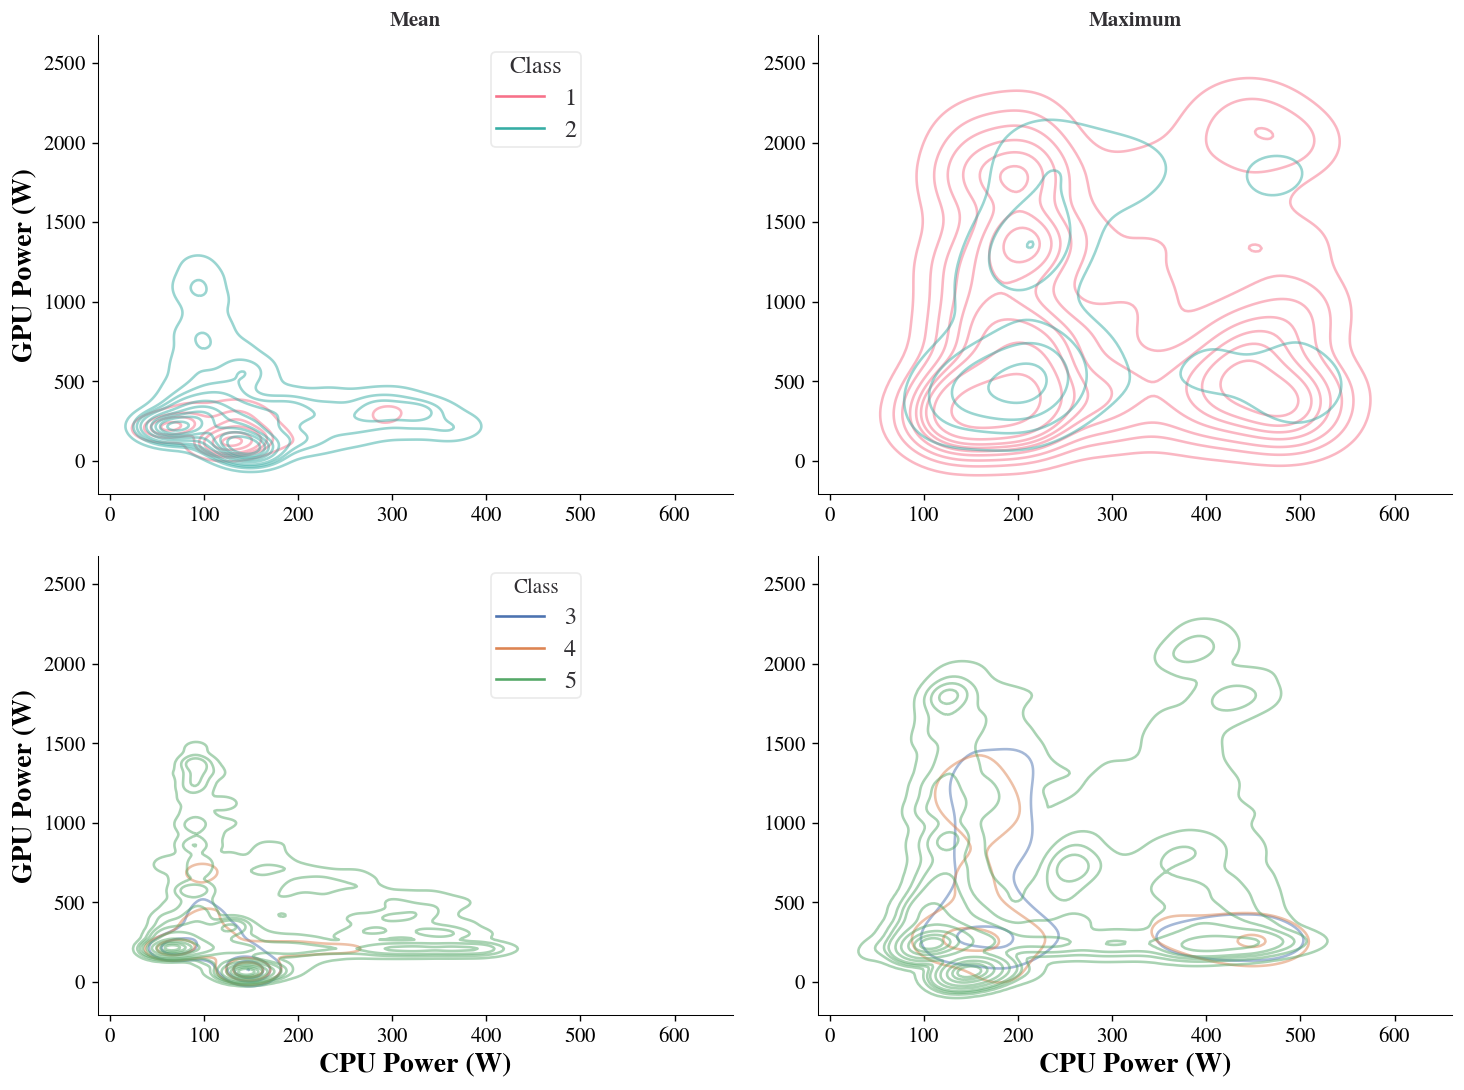

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2, 
                         figsize=(DOUBLE_WIDTH, DOUBLE_WIDTH*3/4))

#Row 1
sns.kdeplot(ax=axes[0,0], x='mean_mean_cpu_pwr', y='mean_mean_gpu_pwr',hue='Class',
            data=plot_df[plot_df['job_type']=='large'].iloc[0:,:],
            alpha=0.5,legend=True, hue_order=['1','2'],fill=False,palette="husl")


axes[0,0].set( xlabel=None)
axes[0,0].annotate("Mean", xy=(0.5, 1), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline', weight='bold',
                  fontsize=12)
axes[0,0].legend_.set_bbox_to_anchor((0.6, 0.99))
axes[0,0].legend_._set_loc(2)
axes[0,0].legend_.get_title().set_fontsize(14)
axes[0,0].set_ylabel("GPU Power (W)",weight='bold')

sns.kdeplot(ax=axes[0,1], x='max_max_cpu_pwr', y='max_max_gpu_pwr',hue='Class',
            data=plot_df[plot_df['job_type']=='large'].iloc[0:,:],
            fill=False,legend=False,alpha=0.5,palette="husl")

axes[0,1].set(ylabel=None, xlabel=None)
axes[0,1].annotate("Maximum", xy=(0.5, 1), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline', weight='bold',
                  fontsize=12)

#Row2
sns.kdeplot(ax=axes[1,0], x='mean_mean_cpu_pwr', y='mean_mean_gpu_pwr',hue='Class',
            data=plot_df[plot_df['job_type']=='small'].iloc[0:,:],legend=True,
            fill=False,alpha=0.5,hue_order=['3','4','5'],palette="deep")
axes[1,0].legend_.set_bbox_to_anchor((0.6, 0.99))
axes[1,0].legend_._set_loc(2)
axes[1,0].legend_.get_title().set_fontsize(12)
axes[1,0].set_xlabel("CPU Power (W)",weight='bold')
axes[1,0].set_ylabel("GPU Power (W)",weight='bold')

sns.kdeplot(ax=axes[1,1], x='max_max_cpu_pwr', y='max_max_gpu_pwr',hue='Class',
            data=plot_df[plot_df['job_type']=='small'].iloc[0:,:],
            fill=False,legend=False,hue_order=['3','4','5'],alpha=0.5,palette="deep")
axes[1,1].set(ylabel=None)
axes[1,1].set_xlabel("CPU Power (W)",weight='bold')

plt.setp(axes, ylim=axes[1,1].get_ylim(),xlim=axes[1,1].get_xlim())
fig.tight_layout()


In [11]:
fig.savefig("../plots/cpu-gpu-kde_nfill.pdf",format='pdf', bbox_inches='tight', pad_inches=0.0)